In [1]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import keras_applications, keras_preprocessing
import re
import cv2
import matplotlib.patches as patches
from sklearn import preprocessing
%matplotlib inline

Using TensorFlow backend.


### check how .csv data look like

In [3]:
data_path = os.path.join(os.getcwd(), 'global-wheat-detection', 'train' + '.' + 'csv')
df_train = pd.DataFrame(pd.read_csv(data_path))
print(df_train.shape)
df_train.head()

(147793, 5)


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


# Data preparation and preprocessing

### writing class to load and plot images
#### visualizing data and bounding boxes

In [4]:
class plot_bbox:
    def __init__(self, image_dir, annot_path, image_num, suffix_):
        self.image_dir = image_dir
        self.annot_path = annot_path
        self.image_num = image_num
        self.suffix_ = suffix_
        
    def load_images(self):
        dir_list = os.listdir(self.image_dir)
        pur_image_names = []
        [pur_image_names.append(img) for img in dir_list if img.endswith('.' + self.suffix_)]
        
        print('%d images are selected at random' % self.image_num)
        
        selected_image_names = np.random.choice(pur_image_names, size = self.image_num)
        
        # start loading images and locate them is 4D array
        images_array = []
        images_array = [cv2.imread(os.path.join(self.image_dir, name)) for name in selected_image_names]
        
        
        return images_array, selected_image_names
    
    def load_annotations(self):
        
        df_ = pd.read_csv(self.annot_path)
        return df_
    
    def plot_(self):
        
        images_, image_names = self.load_images()
        
        df_annot = self.load_annotations()
        
        nr_ = self.image_num
        
        # creating plot
        subplot_row = int(np.ceil(nr_/4))
        subplot_col = 4
        f, axes = plt.subplots(subplot_row, subplot_col, figsize= (14, 3 * subplot_row))
        
        
        for i, ax in enumerate(axes.flat):
            try:
                ax.imshow(images_[i], vmin = 0, vmax = 255)
                ax.set_axis_off()
                ax.set_title(image_names[i])
                # add bbox per image
                # search for all bboxes per image name
                
                boxes = df_annot[df_annot.image_id == image_names[i][:-4]].bbox.values
                
                if 1:
                    for ind in range(boxes.shape[0]):
                        temp_box = re.findall('[0-9.]+', boxes[ind])
                        ax.add_patch(patches.Rectangle((float(temp_box[0]),float(temp_box[1])),
                                                       float(temp_box[2]),float(temp_box[3]),
                                                      linewidth = 1, edgecolor = 'r', 
                                                       facecolor = 'none'))
                
            except:
                ax.set_axis_off()
                print('number of axes are more than images')
            
        plt.show()
        
        
    def plot_given_input(self, input_images, input_image_names, nr_):
        
        images_ = input_images
        image_names = input_image_names
        
        df_annot = self.load_annotations()
        
        
        # creating plot
        subplot_row = int(np.ceil(nr_/4))
        subplot_col = 4
        f, axes = plt.subplots(subplot_row, subplot_col, figsize= (14, 3 * subplot_row))
        
        
        for i, ax in enumerate(axes.flat):
            try:
                ax.imshow(images_[i], vmin = 0, vmax = 255)
                ax.set_axis_off()
                ax.set_title(image_names[i])
                # add bbox per image
                # search for all bboxes per image name
                
                boxes = df_annot[df_annot.image_id == image_names[i][:-4]].bbox.values
                
                if 1:
                    for ind in range(boxes.shape[0]):
                        temp_box = re.findall('[0-9.]+', boxes[ind])
                        ax.add_patch(patches.Rectangle((float(temp_box[0]),float(temp_box[1])),
                                                       float(temp_box[2]),float(temp_box[3]),
                                                      linewidth = 1, edgecolor = 'r', 
                                                       facecolor = 'none'))
                
            except:
                ax.set_axis_off()
                print('number of axes are more than images')
            
        plt.show()

### first visualization

16 images are selected at random


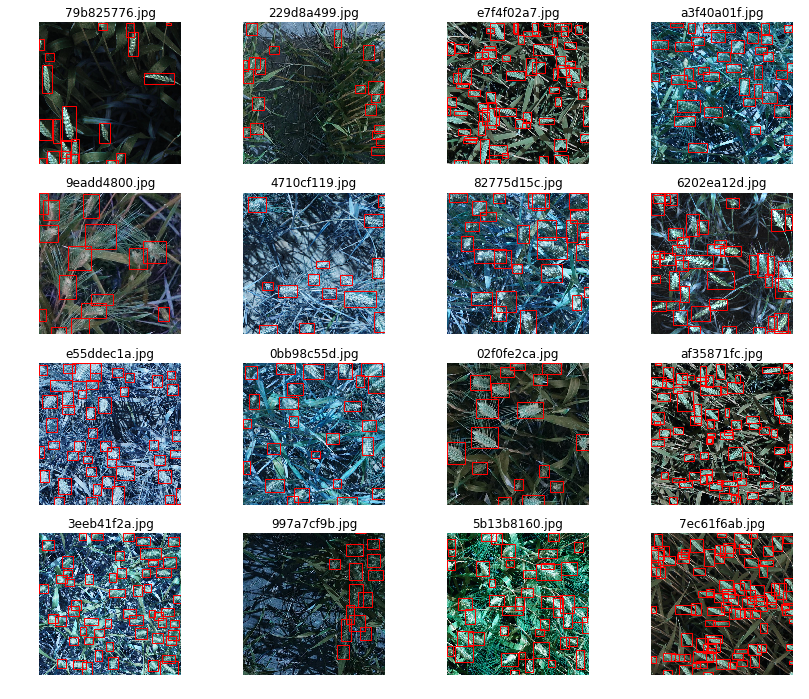

In [5]:

P = plot_bbox(image_dir='C:/Users/Nima/Documents/Kaggle/Global Wheat Detection/global-wheat-detection/train',
             image_num=16,
             annot_path='C:/Users/Nima/Documents/Kaggle/Global Wheat Detection/global-wheat-detection/train.csv',
            suffix_='jpg')
P.plot_()

## Normalization step

In [6]:
# first read all data from image folder
P = plot_bbox(image_dir='C:/Users/Nima/Documents/Kaggle/Global Wheat Detection/global-wheat-detection/train',
             image_num=400,
             annot_path='C:/Users/Nima/Documents/Kaggle/Global Wheat Detection/global-wheat-detection/train.csv',
            suffix_='jpg')
all_images, all_names = P.load_images()
len(all_images)
all_images_array = np.array(all_images)
print(all_images_array.shape)

400 images are selected at random
(400, 1024, 1024, 3)


In [11]:
def per_channel_norm(input_data, standard_, min_max):
    
    n, x, y, ch = input_data.shape
    
    # initialize
    input_data_norm = np.zeros_like(input_data)
    
    # first split channels
    r_channel = input_data[:,:,:,0].reshape(-1,x*y)
    g_channel = input_data[:,:,:,1].reshape(-1,x*y)
    b_channel = input_data[:,:,:,2].reshape(-1,x*y)
    
    if standard_:
    
        r_channel = preprocessing.StandardScaler().fit_transform(r_channel)
        g_channel = preprocessing.StandardScaler().fit_transform(g_channel)
        b_channel = preprocessing.StandardScaler().fit_transform(b_channel)
        
    if min_max:
        
        r_channel = preprocessing.MinMaxScaler().fit_transform(r_channel)
        g_channel = preprocessing.MinMaxScaler().fit_transform(g_channel)
        b_channel = preprocessing.MinMaxScaler().fit_transform(b_channel)
    
    input_data_norm[:,:,:,0] = r_channel.reshape(-1,x,y)
    input_data_norm[:,:,:,1] = g_channel.reshape(-1,x,y)
    input_data_norm[:,:,:,2] = b_channel.reshape(-1,x,y)
    
    
    return input_data_norm
    

In [19]:
# normalizing data then scaling to between 0-1
norm_images = per_channel_norm(all_images_array, False, True)

number of axes are more than images


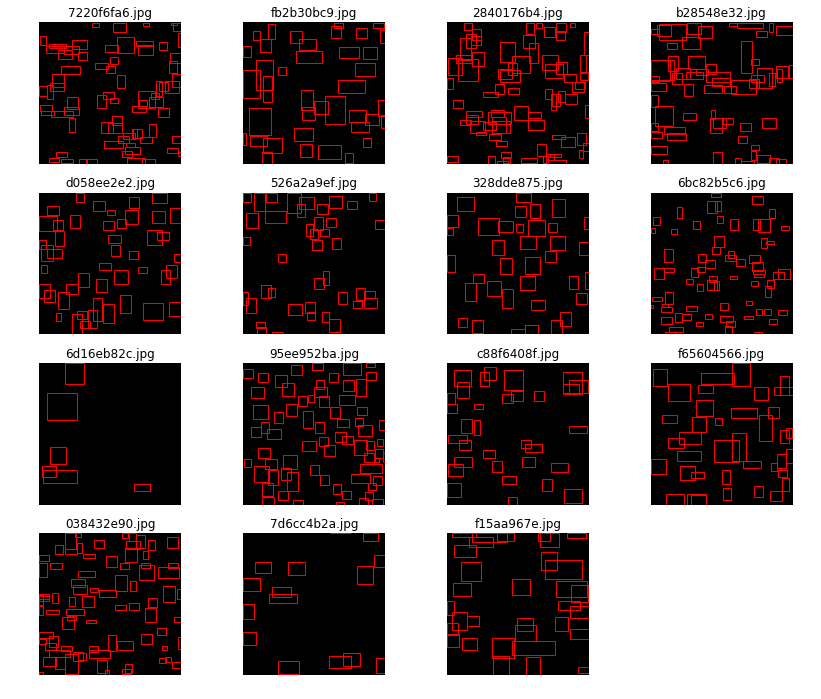

In [20]:
P.plot_given_input(input_images=np.uint8(norm_images[0:15]), input_image_names=all_names[0:15], nr_=16)

'7220f6fa6.jpg'

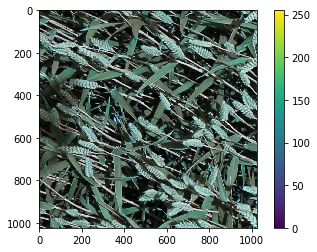

In [37]:
plt.imshow(all_images[0], vmin = 0, vmax = 255)
plt.colorbar()
all_names[0]